In [1]:
from helpers import *

In [2]:
# plot a pretty picture in the current directory called "output.png"
simulator = mendelSim(precision = 100, num_points=100)
simulator.run_sim()

1.4739

In [3]:
# parallelize to speed up
def monteCarlo(precision, num_points, simStrat):
    # no plot simulator
    simulator = mendelSim(precision=precision, num_points=num_points, simStrat = simStrat, draw=False, niceColors=False)
    return simulator.run_sim()

In [4]:
# try to get a good estimate of the influence of num_points (s) and precision(i)
# alter amount of jobs to fit your system
# results for precision
# shuffle the input to enhance time estimate
inputPrecisionSize = 1000
inputPrecision = np.arange(inputPrecisionSize)
np.random.shuffle(inputPrecision)
resultsPrecision = Parallel(n_jobs=8)(delayed(monteCarlo)(simStrat = "random",precision = i, num_points = 10000)
                                      for i in notebook.tqdm(inputPrecision))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
# results for number of points
inputPointSize = 30000
inputPoint = np.arange(inputPointSize)
np.random.shuffle(inputPoint)
resultsPoints = Parallel(n_jobs=8)(delayed(monteCarlo)(simStrat = "random",precision = 100, num_points = i+1)
                                   for i in notebook.tqdm(inputPoint))

  0%|          | 0/30000 [00:00<?, ?it/s]

In [6]:
# investigate the convergence of the two parameters
# convert to np array to enhance speed

arrPrecision = np.array(resultsPrecision)
errorPrecision = abs(arrPrecision - arrPrecision[np.where(inputPrecision == inputPrecisionSize-1)][0])
precisionResult = np.array((inputPrecision, arrPrecision, errorPrecision))


arrPoint = np.array(resultsPoints)
errorPoints = abs(arrPoint - arrPoint[np.where(inputPoint == inputPointSize-1)[0]])
pointResult = np.array((inputPoint, arrPoint, errorPoints))


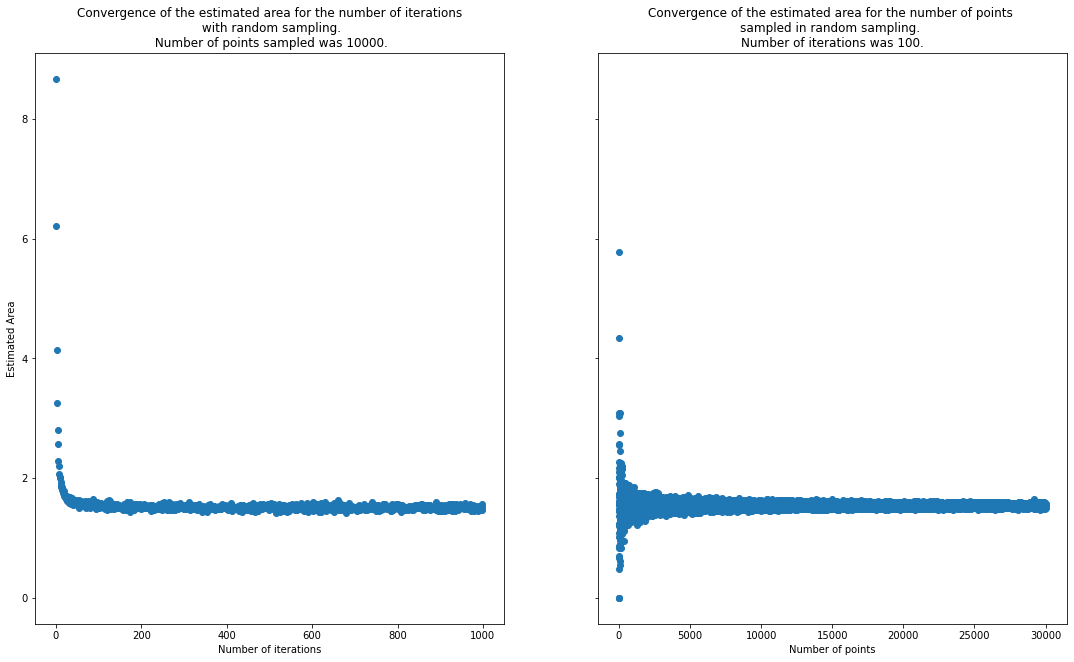

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(18.5, 10.5)
ax1.scatter(precisionResult[0], precisionResult[1])
ax1.set_ylabel("Estimated Area")
ax1.set_xlabel("Number of iterations")
ax1.set_title(f"Convergence of the estimated area for the number of iterations\n with random sampling.\n Number of points sampled was 10000.")

ax2.scatter(pointResult[0], pointResult[1])
ax2.set_xlabel("Number of points")
ax2.set_title(f"Convergence of the estimated area for the number of points \nsampled in random sampling. \nNumber of iterations was 100.")
#ax2.savefig("pointsArea.jpg")
fig.savefig("figures/randomArea.jpg")

([0.6499215644452454,
  0.030370119907382236,
  0.033763720434809526,
  0.035084071481912914,
  0.03077984809442048],
 [1.67435907, 1.517774535, 1.515069495, 1.5132314550000001, 1.51043538])

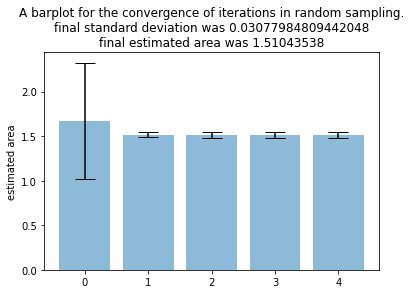

In [8]:
createBars(5, precisionResult, "A barplot for the convergence of iterations in random sampling.", "figures/barPrecision.jpg")

([0.1314464228738365,
  0.03544202369293429,
  0.027215546657904054,
  0.02313594446418996,
  0.020398160742734015],
 [1.548654331556912,
  1.5462869447407228,
  1.5459451639701582,
  1.545932454115006,
  1.5462538723421324])

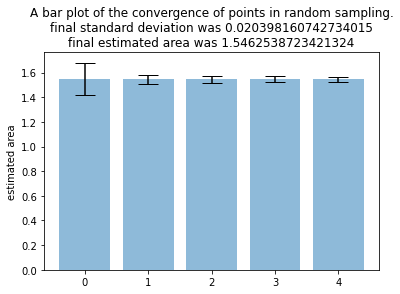

In [9]:
createBars(5, pointResult, "A bar plot of the convergence of points in random sampling.", "figures/barPoint.jpg")

In [10]:
simulator = mendelSim(simStrat = "latin", width = 1000, aspectRatio = 1, precision = 100)
simulator.run_sim()

1.4103199999999998

In [11]:
def monteCarloLatin(precision, width):
    simulator = mendelSim(simStrat = "latin", width = width, aspectRatio = 1, precision = precision, draw=False, niceColors=False)
    return simulator.run_sim()


In [12]:
#test convergence of latin hypercube strategy. This works a little differently, because our input points are dependent on the 
# width of the picture

inputPrecisionSize = 1000
inputPrecision = np.arange(inputPrecisionSize)
np.random.shuffle(inputPrecision)
resultsPrecision = Parallel(n_jobs=8)(delayed(monteCarloLatin)(precision = i, width = 10000)
                                      for i in notebook.tqdm(inputPrecision))

arrPrecision = np.array(resultsPrecision)
errorPrecision = abs(arrPrecision - arrPrecision[np.where(inputPrecision == inputPrecisionSize-1)][0])
precisionResult = np.array((inputPrecision, arrPrecision, errorPrecision))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
inputPointSize = 10000
inputPoint = np.arange(inputPointSize)
np.random.shuffle(inputPoint)
resultsPoint = Parallel(n_jobs=8)(delayed(monteCarloLatin)(precision = 100, width = i+1)
                                      for i in notebook.tqdm(inputPoint))

arrPoint = np.array(resultsPoint)
errorPoint = abs(arrPoint - arrPoint[np.where(inputPoint == inputPointSize-1)][0])
pointResult = np.array((inputPoint, arrPoint, errorPoint))

  0%|          | 0/10000 [00:00<?, ?it/s]

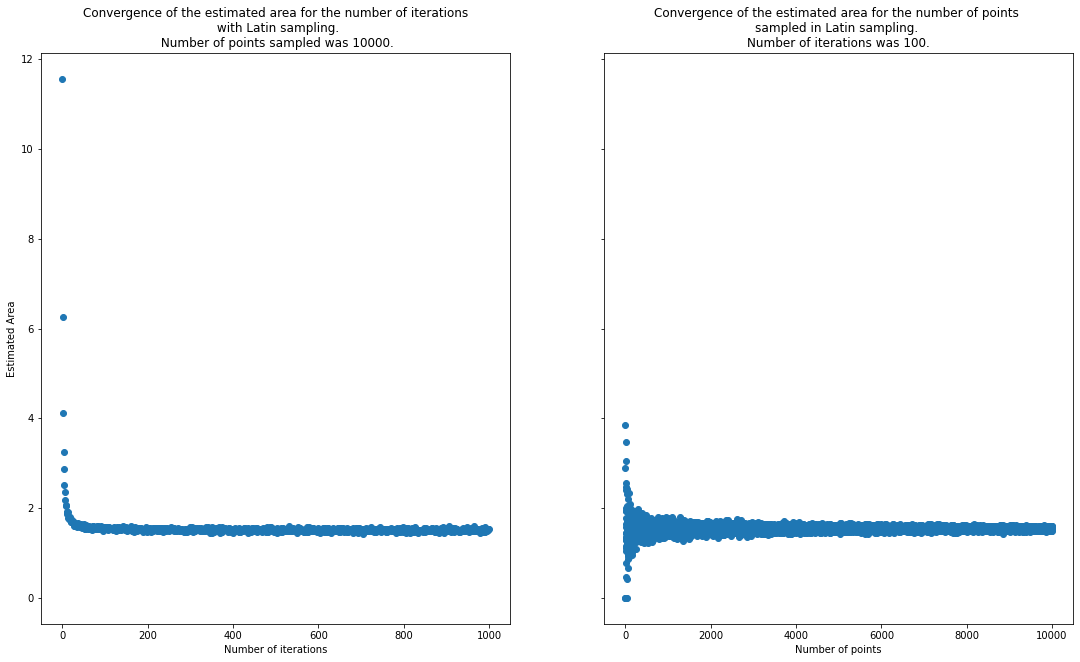

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(18.5, 10.5)
ax1.scatter(precisionResult[0], precisionResult[1])
ax1.set_ylabel("Estimated Area")
ax1.set_xlabel("Number of iterations")
ax1.set_title(f"Convergence of the estimated area for the number of iterations\n with Latin sampling.\n Number of points sampled was 10000.")

ax2.scatter(pointResult[0], pointResult[1])
ax2.set_xlabel("Number of points")
ax2.set_title(f"Convergence of the estimated area for the number of points \nsampled in Latin sampling. \nNumber of iterations was 100.")

fig.savefig("figures/latinArea.jpg")

([0.8165611645448921,
  0.028931296781831276,
  0.02834242257760619,
  0.028706666039448055,
  0.02909589308025447],
 [1.6914476399999998,
  1.51995504,
  1.51540618,
  1.5137068599999999,
  1.5117936799999998])

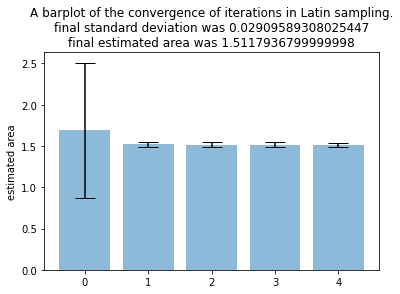

In [15]:
createBars(5, precisionResult, "A barplot of the convergence of iterations in Latin sampling.", "figures/barPrecisionLatin.jpg")

([0.17535943414496002,
  0.05327895428337912,
  0.04066525531542956,
  0.033422819702862705,
  0.02907513593382341],
 [1.546805853069844,
  1.5475079256410627,
  1.5446517374186874,
  1.5460608719941784,
  1.5457988657971884])

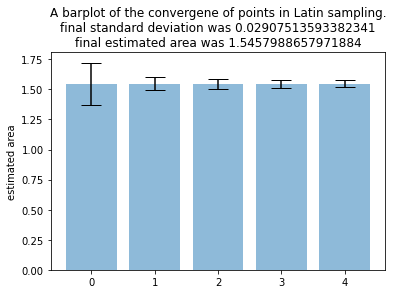

In [16]:
createBars(5, pointResult,  "A barplot of the convergene of points in Latin sampling.", "figures/barPointLatin.jpg")

In [17]:
simulator = mendelSim(simStrat = "orthogonalFast", width = 8**2, aspectRatio = 1, precision = 100)
simulator.run_sim()

1.0837499999999998

In [18]:
def monteCarloOrtho(precision, width):
    simulator = mendelSim(simStrat = "orthogonalFast", width = width, aspectRatio = 1, precision = precision, draw=False, niceColors=False)
    return simulator.run_sim()

In [19]:
#test convergence of orthogonal latin hypercube strategy. This works a little differently, 
# because our input points are dependent on the square of the width of the picture

inputPrecisionSize = 1000
inputPrecision = np.arange(inputPrecisionSize)
np.random.shuffle(inputPrecision)
resultsPrecision = Parallel(n_jobs=8)(delayed(monteCarloOrtho)(precision = i, width = 10000)
                                      for i in notebook.tqdm(inputPrecision))

arrPrecision = np.array(resultsPrecision)
errorPrecision = abs(arrPrecision - arrPrecision[np.where(inputPrecision == inputPrecisionSize-1)][0])
precisionResult = np.array((inputPrecision, arrPrecision, errorPrecision))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
inputPointSize = 173
inputPoint = (np.arange(inputPointSize)+1)**2
np.random.shuffle(inputPoint)
resultsPoint = Parallel(n_jobs=6)(delayed(monteCarloOrtho)(precision = 100, width = i)
                                      for i in notebook.tqdm(inputPoint))

arrPoint = np.array(resultsPoint)
pointResult = np.array((inputPoint, arrPoint))

  0%|          | 0/173 [00:00<?, ?it/s]

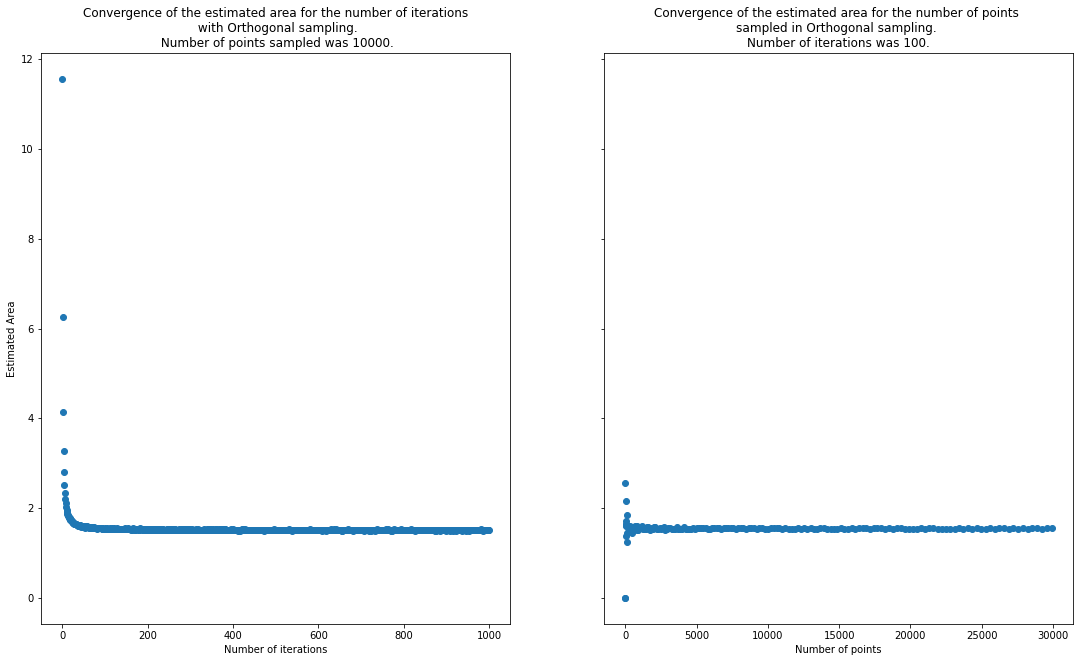

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(18.5, 10.5)
ax1.scatter(precisionResult[0], precisionResult[1])
ax1.set_ylabel("Estimated Area")
ax1.set_xlabel("Number of iterations")
ax1.set_title(f"Convergence of the estimated area for the number of iterations\n with Orthogonal sampling.\n Number of points sampled was 10000.")

ax2.scatter(pointResult[0], pointResult[1])
ax2.set_xlabel("Number of points")
ax2.set_title(f"Convergence of the estimated area for the number of points \nsampled in Orthogonal sampling. \nNumber of iterations was 100.")

fig.savefig("figures/orthoArea.jpg")

([0.8163485478693335,
  0.006969038305849682,
  0.006038855374158253,
  0.006647663410372104,
  0.005676416142567437],
 [1.6908465199999996,
  1.51902446,
  1.5133484999999995,
  1.5115046799999998,
  1.50967242])

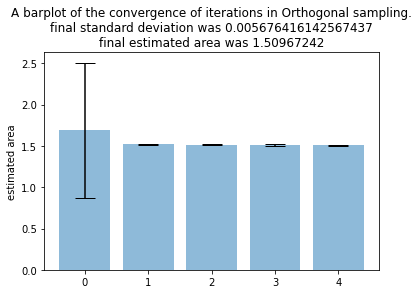

In [22]:
createBars(5, precisionResult, "A barplot of the convergence of iterations in Orthogonal sampling.", "figures/barPrecisionOrtho.jpg")

([0.4362109854790662,
  0.01847394141504208,
  0.007665385839427501,
  0.0062245235797531604,
  0.005205889423182067],
 [1.5064705433314618,
  1.5457683816405734,
  1.5482321997788144,
  1.5458081242264585,
  1.5443972861058075])

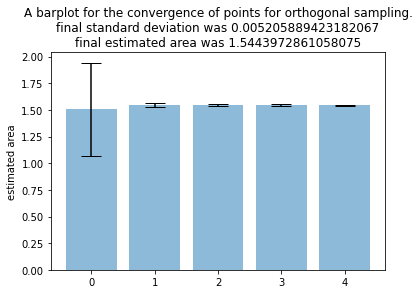

In [23]:
createBars(5, pointResult, "A barplot for the convergence of points for orthogonal sampling.", "figures/barPointOrtho.jpg")

In [24]:
simulator = mendelSim(simStrat = "antiThetic",num_points = 1000, x = -0.5, aspectRatio = 3, precision = 100)
simulator.run_sim()

1.5952799999999998

In [25]:
def monteCarloAnti(precision, num_points):
    # no plot simulator
    simulator = mendelSim(x = -0.5, aspectRatio = 3, precision=precision, num_points=num_points, 
                          simStrat = "antiThetic", draw=False, niceColors=False)
    return simulator.run_sim()

In [26]:
inputPrecisionSize = 1000
inputPrecision = np.arange(inputPrecisionSize)
np.random.shuffle(inputPrecision)
resultsPrecision = Parallel(n_jobs=8)(delayed(monteCarloAnti)(precision = i, num_points = 10000)
                                      for i in notebook.tqdm(inputPrecision))

arrPrecision = np.array(resultsPrecision)
errorPrecision = abs(arrPrecision - arrPrecision[np.where(inputPrecision == inputPrecisionSize-1)][0])
precisionResult = np.array((inputPrecision, arrPrecision, errorPrecision))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
inputPointSize = 10000
inputPoint = np.arange(inputPointSize)
np.random.shuffle(inputPoint)
resultsPoint = Parallel(n_jobs=8)(delayed(monteCarloAnti)(precision = 100, num_points = i+2)
                                      for i in notebook.tqdm(inputPoint))

arrPoint = np.array(resultsPoint)
errorPoint = abs(arrPoint - arrPoint[np.where(inputPoint == inputPointSize-1)][0])
pointResult = np.array((inputPoint, arrPoint, errorPoint))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(18.5, 10.5)
ax1.scatter(precisionResult[0], precisionResult[1])
ax1.set_ylabel("Estimated Area")
ax1.set_xlabel("Number of iterations")
ax1.set_title(f"Convergence of the estimated area for the number of iterations\n with Antithetic sampling.\n Number of points sampled was 10000.")

ax2.scatter(pointResult[0], pointResult[1])
ax2.set_xlabel("Number of points")
ax2.set_title(f"Convergence of the estimated area for the number of points \nsampled in Antithetic sampling. \nNumber of iterations was 100.")

fig.savefig("figures/antiArea.jpg")

In [ ]:
createBars(5, precisionResult, "A barplot of the convergence of iterations in Antithetic sampling.", "figures/barPrecisionAnti.jpg")

In [ ]:
createBars(5, pointResult,  "A barplot of the convergence of points in antithetic sampling.", "figures/barPointAnti.jpg")